# Install

In [1]:
!pip install sentencepiece

     |████████████████████████████████| 1.2MB 9.7MB/s 


# Evn

In [2]:
import os
import random
import shutil
import json
import zipfile
import math
import copy
import collections
import re

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sentencepiece as spm
import tensorflow as tf
import tensorflow.keras.backend as KK

from tqdm.notebook import tqdm

In [3]:
# random seed initialize
random_seed = 1234
random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

In [4]:
!nvidia-smi

Fri Feb  5 14:04:49 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
# google drive mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# data dir
data_dir = '/content/drive/MyDrive/NLP_data'
os.listdir(data_dir)

['ko_32000.model',
 'ko_32000.vocab',
 'kowiki',
 '.ipynb_checkpoints',
 'nsmc',
 'quora',
 'songys']

In [7]:
# songys chatbot dir
songys_dir = os.path.join(data_dir, 'songys')
if not os.path.exists(songys_dir):
    os.makedirs(songys_dir)
os.listdir(songys_dir)

['ChatbotData.csv', 'lstm.csv', 'lstm.hdf5', 'lstm_dot.csv', 'lstm_dot.hdf5']

# Attention

In [8]:
# 입력 문장
sentences = [
    ['나는 오늘 기분이 좋아', '네가 좋으니 나도 좋아'],
    ['나는 오늘 행복해', '나도 행복하다'],
]

In [9]:
# 각 문장을 띄어쓰기 단위로 분할
words = []
for pair in sentences:
    for sentence in pair:
        words.extend(sentence.split())

# 중복 단어 제거
words = list(dict.fromkeys(words))

# 각 단어별 고유한 번호 부여
word_to_id = {'[PAD]': 0, '[UNK]': 1, '[BOS]': 2, '[EOS]': 3}
for word in words:
    word_to_id[word] = len(word_to_id)

# 각 숫자별 단어 부여
id_to_word = {_id:word for word, _id in word_to_id.items()}

word_to_id, id_to_word

({'[BOS]': 2,
  '[EOS]': 3,
  '[PAD]': 0,
  '[UNK]': 1,
  '기분이': 6,
  '나는': 4,
  '나도': 10,
  '네가': 8,
  '오늘': 5,
  '좋아': 7,
  '좋으니': 9,
  '행복하다': 12,
  '행복해': 11},
 {0: '[PAD]',
  1: '[UNK]',
  2: '[BOS]',
  3: '[EOS]',
  4: '나는',
  5: '오늘',
  6: '기분이',
  7: '좋아',
  8: '네가',
  9: '좋으니',
  10: '나도',
  11: '행복해',
  12: '행복하다'})

In [10]:
# Question과 Answer를 숫자료
question_list, answer_list = [], []

for pair in sentences:
    question_list.append([word_to_id[word] for word in pair[0].split()])
    answer_list.append([word_to_id[word] for word in pair[1].split()])

# 학습용 입력 데이터 생성
train_enc_inputs, train_dec_inputs, train_labels = [], [], []

for question, answer in zip(question_list, answer_list):
    train_enc_inputs.append(question)
    train_dec_inputs.append([word_to_id['[BOS]']] + answer)
    train_labels.append(answer + [word_to_id['[EOS]']])

# Encoder 입력의 길이를 모두 동일하게 변경 (최대길이 4)
for row in train_enc_inputs:
    row += [0] * (4 - len(row))

# Decoder 입력의 길이를 모두 동일하게 변경 (최대길이 5)
for row in train_dec_inputs:
    row += [0] * (5 - len(row))

# 정답의 길이를 모두 동일하게 변경 (최대길이 5)
for row in train_labels:
    row += [0] * (5 - len(row))

# numpy array로 변환
train_enc_inputs = np.array(train_enc_inputs)
train_dec_inputs = np.array(train_dec_inputs)
train_labels = np.array(train_labels)

train_enc_inputs, train_dec_inputs, train_labels

(array([[ 4,  5,  6,  7],
        [ 4,  5, 11,  0]]), array([[ 2,  8,  9, 10,  7],
        [ 2, 10, 12,  0,  0]]), array([[ 8,  9, 10,  7,  3],
        [10, 12,  3,  0,  0]]))

In [11]:
# random embed weight
embed_weight = np.random.randint(-9, 9, (len(id_to_word), 5)) / 10

# embedding 생성
embedding = tf.keras.layers.Embedding(len(id_to_word), 5, weights=[embed_weight])

# word embedding
hidden_enc = embedding(train_enc_inputs)  # (bs, n_enc_seq, 5)
hidden_dec = embedding(train_dec_inputs)  # (bs, n_dec_seq, 5)
hidden_enc, hidden_dec

(<tf.Tensor: shape=(2, 4, 5), dtype=float32, numpy=
 array([[[ 0.2, -0.9,  0. ,  0.2,  0.7],
         [-0.6, -0.7,  0.3, -0.8,  0.2],
         [ 0.2,  0.8,  0.5, -0.2,  0.1],
         [ 0.2,  0.5,  0.8,  0.4, -0.9]],
 
        [[ 0.2, -0.9,  0. ,  0.2,  0.7],
         [-0.6, -0.7,  0.3, -0.8,  0.2],
         [-0.4,  0.4, -0.3, -0.2, -0.5],
         [ 0.6, -0.3,  0.3,  0.6,  0.8]]], dtype=float32)>,
 <tf.Tensor: shape=(2, 5, 5), dtype=float32, numpy=
 array([[[ 0.7,  0. ,  0.6,  0.7,  0.3],
         [ 0.3, -0.4,  0.8, -0.4,  0.4],
         [ 0.7,  0. , -0.1,  0.3, -0.3],
         [ 0.3,  0.6,  0.8,  0.5, -0.7],
         [ 0.2,  0.5,  0.8,  0.4, -0.9]],
 
        [[ 0.7,  0. ,  0.6,  0.7,  0.3],
         [ 0.3,  0.6,  0.8,  0.5, -0.7],
         [-0.6, -0.4,  0.5,  0.6,  0.6],
         [ 0.6, -0.3,  0.3,  0.6,  0.8],
         [ 0.6, -0.3,  0.3,  0.6,  0.8]]], dtype=float32)>)

In [12]:
# Q, K, V 선언
# Q = decoder, K, V = encoder
Q = hidden_dec
K = hidden_enc
V = K

In [13]:
# Q[0][0] & K[0][0]
q_idx, k_idx = 0, 0
q_val = Q[0][q_idx]
k_val = K[0][k_idx]
print(q_val)
print(k_val)
print(np.dot(q_val, np.transpose(k_val)))
print(tf.matmul([q_val], [k_val], transpose_b = True))
print(np.sum(q_val * k_val))

tf.Tensor([0.7 0.  0.6 0.7 0.3], shape=(5,), dtype=float32)
tf.Tensor([ 0.2 -0.9  0.   0.2  0.7], shape=(5,), dtype=float32)
0.49
tf.Tensor([[0.49]], shape=(1, 1), dtype=float32)
0.49


In [14]:
# Q[0][0] & K[0][1]
q_idx, k_idx = 0, 1
q_val = Q[0][q_idx]
k_val = K[0][k_idx]
print(q_val)
print(k_val)
print(np.dot(q_val, np.transpose(k_val)))
print(tf.matmul([q_val], [k_val], transpose_b = True))
print(np.sum(q_val * k_val))

tf.Tensor([0.7 0.  0.6 0.7 0.3], shape=(5,), dtype=float32)
tf.Tensor([-0.6 -0.7  0.3 -0.8  0.2], shape=(5,), dtype=float32)
-0.74
tf.Tensor([[-0.74]], shape=(1, 1), dtype=float32)
-0.74


In [15]:
# Q[0][0] & K[0][2]
q_idx, k_idx = 0, 2
q_val = Q[0][q_idx]
k_val = K[0][k_idx]
print(q_val)
print(k_val)
print(np.dot(q_val, np.transpose(k_val)))
print(tf.matmul([q_val], [k_val], transpose_b = True))
print(np.sum(q_val * k_val))

tf.Tensor([0.7 0.  0.6 0.7 0.3], shape=(5,), dtype=float32)
tf.Tensor([ 0.2  0.8  0.5 -0.2  0.1], shape=(5,), dtype=float32)
0.33
tf.Tensor([[0.33]], shape=(1, 1), dtype=float32)
0.33


In [16]:
# Q[0][0] & K[0][3]
q_idx, k_idx = 0, 3
q_val = Q[0][q_idx]
k_val = K[0][k_idx]
print(q_val)
print(k_val)
print(np.dot(q_val, np.transpose(k_val)))
print(tf.matmul([q_val], [k_val], transpose_b = True))
print(np.sum(q_val * k_val))

tf.Tensor([0.7 0.  0.6 0.7 0.3], shape=(5,), dtype=float32)
tf.Tensor([ 0.2  0.5  0.8  0.4 -0.9], shape=(5,), dtype=float32)
0.63
tf.Tensor([[0.63]], shape=(1, 1), dtype=float32)
0.63


In [17]:
# Q[0][0] & K[0][*]q_idx, k_idx = 0, 3
attn_now = []
q_val = Q[0][0]
print(q_val)
for k_idx in range(4):
  k_val = K[0][k_idx]
  attn_now.append(tf.matmul([q_val], [k_val], transpose_b = True).numpy()[0][0])
attn_now

tf.Tensor([0.7 0.  0.6 0.7 0.3], shape=(5,), dtype=float32)


[0.49, -0.74, 0.33, 0.63]

In [18]:
# Q[0][*] & K[0][*]
for q_idx in range(5):
  q_val = Q[0][q_idx]
  attn_now = []
  for k_idx in range(4):
    k_val = K[0][k_idx]
    attn_now.append(tf.matmul([q_val], [k_val], transpose_b = True).numpy()[0][0])
  print(attn_now)

[0.49, -0.74, 0.33, 0.63]
[0.62, 0.74, 0.26, -0.019999951]
[-0.010000005, -0.75000006, 0.0, 0.45000002]
[-0.87, -0.9, 0.77000004, 1.83]
[-0.96, -0.73, 0.6700001, 1.9]


In [19]:
# attention score
attn_score = tf.matmul(Q, K, transpose_b=True).numpy()
attn_score

array([[[ 0.49      , -0.74      ,  0.33      ,  0.63      ],
        [ 0.62      ,  0.74      ,  0.26      , -0.01999995],
        [-0.01000001, -0.75000006,  0.        ,  0.45000002],
        [-0.87      , -0.9       ,  0.77000004,  1.83      ],
        [-0.96      , -0.73      ,  0.6700001 ,  1.9       ]],

       [[ 0.49      , -0.74      , -0.75      ,  1.26      ],
        [-0.87      , -0.9       ,  0.13      , -0.01999998],
        [ 0.78      ,  0.42999995, -0.49      ,  0.75      ],
        [ 1.0699999 , -0.38      , -0.97      ,  1.5400001 ],
        [ 1.0699999 , -0.38      , -0.97      ,  1.5400001 ]]],
      dtype=float32)

In [20]:
# attention prob
attn_prob = tf.nn.softmax(attn_score, axis=-1).numpy()
attn_prob

array([[[0.30351683, 0.08871571, 0.25863996, 0.34912744],
        [0.2982879 , 0.3363187 , 0.20810843, 0.15728496],
        [0.24562553, 0.11719136, 0.24809413, 0.38908905],
        [0.0454435 , 0.04410044, 0.23426896, 0.6761871 ],
        [0.0402836 , 0.05070093, 0.20560242, 0.70341307]],

       [[0.26727656, 0.07812295, 0.07734562, 0.5772549 ],
        [0.14228041, 0.13807541, 0.38675827, 0.3328859 ],
        [0.33829898, 0.23839524, 0.09500505, 0.32830074],
        [0.33731437, 0.07912394, 0.04386055, 0.53970116],
        [0.33731437, 0.07912394, 0.04386055, 0.53970116]]], dtype=float32)

In [21]:
# prob sum 확인
np.sum(attn_prob, axis=-1)

array([[0.9999999, 1.       , 1.       , 1.       , 1.       ],
       [1.       , 1.       , 1.       , 1.       , 1.       ]],
      dtype=float32)

In [22]:
# attn_prov[0][0][0] & V[0][0]
p_idx, v_idx = 0, 0 
p_val = attn_prob[0][0][p_idx]
v_val = V[0][v_idx]
print(p_val)
print(v_val)
attn_out_000 = p_val * v_val
attn_out_000

0.30351683
tf.Tensor([ 0.2 -0.9  0.   0.2  0.7], shape=(5,), dtype=float32)


<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([ 0.06070337, -0.27316514,  0.        ,  0.06070337,  0.21246178],
      dtype=float32)>

In [23]:
# attn_prov[0][0][1] & V[0][1]
p_idx, v_idx = 1, 1
p_val = attn_prob[0][0][p_idx]
v_val = V[0][v_idx]
print(p_val)
print(v_val)
attn_out_001 = p_val * v_val
attn_out_001

0.08871571
tf.Tensor([-0.6 -0.7  0.3 -0.8  0.2], shape=(5,), dtype=float32)


<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([-0.05322943, -0.062101  ,  0.02661471, -0.07097257,  0.01774314],
      dtype=float32)>

In [24]:
# attn_prov[0][0][2] & V[0][2]
p_idx, v_idx = 2,2
p_val = attn_prob[0][0][p_idx]
v_val = V[0][v_idx]
print(p_val)
print(v_val)
attn_out_002 = p_val * v_val
attn_out_002

0.25863996
tf.Tensor([ 0.2  0.8  0.5 -0.2  0.1], shape=(5,), dtype=float32)


<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([ 0.05172799,  0.20691197,  0.12931998, -0.05172799,  0.025864  ],
      dtype=float32)>

In [25]:
# attn_prov[0][0][3] & V[0][3]
p_idx, v_idx = 3,3
p_val = attn_prob[0][0][p_idx]
v_val = V[0][v_idx]
print(p_val)
print(v_val)
attn_out_003 = p_val * v_val
attn_out_003

0.34912744
tf.Tensor([ 0.2  0.5  0.8  0.4 -0.9], shape=(5,), dtype=float32)


<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([ 0.06982549,  0.17456372,  0.27930197,  0.13965099, -0.31421468],
      dtype=float32)>

In [26]:
# attn_prov[0][0][*] & V[0][*]
attn_out_00 = attn_out_000 + attn_out_001 + attn_out_002 + attn_out_003

In [27]:
# attn_prov[0][0][*] & V[0][*]
attn_row = []
for v_idx in range(4):
  attn_row.append(attn_prob[0][q_idx][v_idx] * V[0][v_idx])
print(np.sum(attn_row, axis=0))

[ 0.15943927  0.44444257  0.68074197  0.20774074 -0.5741728 ]


In [28]:
# attn_prov[0][*] & V[0][*]
for q_idx in range(5):
    attn_row = []
    for v_idx in range(4):
        attn_row.append(attn_prob[0][q_idx][v_idx] * V[0][v_idx])
    print(np.sum(attn_row, axis=0))

[ 0.12902743  0.04620954  0.43523666  0.0776538  -0.05814576]
[-0.06905498 -0.25875294  0.3307778  -0.1881051   0.15531965]
[ 0.10624693  0.0899229   0.47047573  0.06138881 -0.12999457]
[ 0.16471966  0.45373926  0.6713143   0.1974294  -0.54451096]
[ 0.15943927  0.44444257  0.68074197  0.20774074 -0.5741728 ]


In [29]:
# attn_prov & V
attn_out = tf.matmul(attn_prob, V)
attn_out

<tf.Tensor: shape=(2, 5, 5), dtype=float32, numpy=
array([[[ 0.12902743,  0.04620954,  0.43523666,  0.07765379,
         -0.05814578],
        [-0.06905498, -0.25875294,  0.3307778 , -0.18810509,
          0.15531965],
        [ 0.10624693,  0.0899229 ,  0.47047573,  0.06138882,
         -0.12999459],
        [ 0.16471964,  0.45373926,  0.6713143 ,  0.1974294 ,
         -0.54451096],
        [ 0.15943927,  0.44444263,  0.68074197,  0.20774072,
         -0.5741728 ]],

       [[ 0.32199624, -0.43747318,  0.17340967,  0.3218408 ,
          0.6258493 ],
        [-0.00936093, -0.16986763,  0.02526091,  0.04037564,
          0.20014095],
        [ 0.08360107, -0.53183395,  0.1415073 ,  0.05492304,
          0.4996264 ],
        [ 0.326265  , -0.50333583,  0.17248936,  0.31921232,
          0.66177547],
        [ 0.326265  , -0.50333583,  0.17248936,  0.31921232,
          0.66177547]]], dtype=float32)>

In [30]:
class DotProductAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, inputs):
        Q, K, V = inputs
        #####################################
        # attention score (dot-product)
        attn_score = tf.matmul(Q, K, transpose_b=True)
        # attention prov
        attn_prob = tf.nn.softmax(attn_score)
        # weighted sum
        attn_out = tf.matmul(attn_prob, V)
        #####################################
        return attn_out

In [31]:
attention = DotProductAttention()
attention((Q, K, V))

<tf.Tensor: shape=(2, 5, 5), dtype=float32, numpy=
array([[[ 0.12902743,  0.04620954,  0.43523666,  0.07765379,
         -0.05814578],
        [-0.06905498, -0.25875294,  0.3307778 , -0.18810509,
          0.15531965],
        [ 0.10624693,  0.0899229 ,  0.47047573,  0.06138882,
         -0.12999459],
        [ 0.16471964,  0.45373926,  0.6713143 ,  0.1974294 ,
         -0.54451096],
        [ 0.15943927,  0.44444263,  0.68074197,  0.20774072,
         -0.5741728 ]],

       [[ 0.32199624, -0.43747318,  0.17340967,  0.3218408 ,
          0.6258493 ],
        [-0.00936093, -0.16986763,  0.02526091,  0.04037564,
          0.20014095],
        [ 0.08360107, -0.53183395,  0.1415073 ,  0.05492304,
          0.4996264 ],
        [ 0.326265  , -0.50333583,  0.17248936,  0.31921232,
          0.66177547],
        [ 0.326265  , -0.50333583,  0.17248936,  0.31921232,
          0.66177547]]], dtype=float32)>

# 모델링

In [32]:
# word embedding
hidden_enc = embedding(train_enc_inputs)  # (bs, n_enc_seq, 5)
hidden_dec = embedding(train_dec_inputs)  # (bs, n_dec_seq, 5)
hidden_enc, hidden_dec

(<tf.Tensor: shape=(2, 4, 5), dtype=float32, numpy=
 array([[[ 0.2, -0.9,  0. ,  0.2,  0.7],
         [-0.6, -0.7,  0.3, -0.8,  0.2],
         [ 0.2,  0.8,  0.5, -0.2,  0.1],
         [ 0.2,  0.5,  0.8,  0.4, -0.9]],
 
        [[ 0.2, -0.9,  0. ,  0.2,  0.7],
         [-0.6, -0.7,  0.3, -0.8,  0.2],
         [-0.4,  0.4, -0.3, -0.2, -0.5],
         [ 0.6, -0.3,  0.3,  0.6,  0.8]]], dtype=float32)>,
 <tf.Tensor: shape=(2, 5, 5), dtype=float32, numpy=
 array([[[ 0.7,  0. ,  0.6,  0.7,  0.3],
         [ 0.3, -0.4,  0.8, -0.4,  0.4],
         [ 0.7,  0. , -0.1,  0.3, -0.3],
         [ 0.3,  0.6,  0.8,  0.5, -0.7],
         [ 0.2,  0.5,  0.8,  0.4, -0.9]],
 
        [[ 0.7,  0. ,  0.6,  0.7,  0.3],
         [ 0.3,  0.6,  0.8,  0.5, -0.7],
         [-0.6, -0.4,  0.5,  0.6,  0.6],
         [ 0.6, -0.3,  0.3,  0.6,  0.8],
         [ 0.6, -0.3,  0.3,  0.6,  0.8]]], dtype=float32)>)

In [33]:
# encoder lstm
fw_cell = tf.keras.layers.LSTM(units=4, return_state=True, return_sequences=True)
bw_cell = tf.keras.layers.LSTM(units=4, go_backwards=True, return_state=True, return_sequences=True)
lstm_enc = tf.keras.layers.Bidirectional(fw_cell, backward_layer=bw_cell)
hidden_enc, fw_h, fw_c, bw_h, bw_c = lstm_enc(hidden_enc)  # (bs, d_model * 2), (bs, d_model), (bs, d_model), (bs, d_model), (bs, d_model)
hidden_enc.shape, fw_h.shape, fw_c.shape, bw_h.shape, bw_c.shape


(TensorShape([2, 4, 8]),
 TensorShape([2, 4]),
 TensorShape([2, 4]),
 TensorShape([2, 4]),
 TensorShape([2, 4]))

In [34]:
# concat hidden & cell
s_h = tf.concat([fw_h, bw_h], axis=-1)  # (bs, d_model * 2)
s_c = tf.concat([fw_c, bw_c], axis=-1)  # (bs, d_model * 2)
s_h.shape, s_c.shape

(TensorShape([2, 8]), TensorShape([2, 8]))

In [35]:
# decoder LSTM
lstm_dec = tf.keras.layers.LSTM(units=8, return_sequences=True)
hidden_dec = lstm_dec(hidden_dec, initial_state=[s_h, s_c])  # (bs, n_dec_seq, d_model)
hidden_dec.shape

TensorShape([2, 5, 8])

In [36]:
# attention
attention = DotProductAttention()
attn_out = attention((hidden_dec, hidden_enc, hidden_enc))
attn_out.shape

TensorShape([2, 5, 8])

In [37]:
# concat output
dec_out = tf.concat([attn_out, hidden_dec], axis=-1)
dec_out.shape

TensorShape([2, 5, 16])

In [38]:
# 다음단어 예측
dense_out = tf.keras.layers.Dense(units=len(word_to_id), activation=tf.nn.softmax)
outputs = dense_out(dec_out)  # (bs, n_dec_seq, n_vocab)
outputs.shape

TensorShape([2, 5, 13])

In [39]:
def build_model(n_vocab, d_model, n_enc_seq, n_dec_seq):
    """
    seq2seq 모델
    :param n_vocab: vocabulary 단어 수
    :param d_model: 단어를 의미하는 벡터의 차원 수
    :param n_enc_seq: encoder 문장 길이 (단어 수)
    :param n_dec_seq: decoder 문장 길이 (단어 수)
    """
    inputs_enc = tf.keras.layers.Input((n_enc_seq,))  # (bs, n_enc_seq)
    inputs_dec = tf.keras.layers.Input((n_dec_seq,))  # (bs, n_dec_seq)
    ################################################
    # 입력 단어를 vector로 변환
    embedding = tf.keras.layers.Embedding(n_vocab, d_model)
    hidden_enc = embedding(inputs_enc)  # (bs, n_enc_seq, d_model)
    hidden_dec = embedding(inputs_dec)  # (bs, n_dec_seq, d_model)

    # Encoder LSTM (uni-direction, bi-direction 가능)
    fw_cell = tf.keras.layers.LSTM(units=d_model, return_state=True)
    bw_cell = tf.keras.layers.LSTM(units=d_model, go_backwards=True, return_state=True)
    lstm_enc = tf.keras.layers.Bidirectional(fw_cell, backward_layer=bw_cell)
    hidden_enc, fw_h, fw_c, bw_h, bw_c = lstm_enc(hidden_enc)  # (bs, d_model * 2), (bs, d_model), (bs, d_model), (bs, d_model), (bs, d_model)

    # Concatenate hidden states and cell states
    s_h = tf.concat([fw_h, bw_h], axis=-1)  # (bs, d_model * 2)
    s_c = tf.concat([fw_c, bw_c], axis=-1)  # (bs, d_model * 2)

    # Decoder LSTM (uni-direction만 가능)
    lstm_dec = tf.keras.layers.LSTM(units=d_model * 2, return_sequences=True)
    hidden_dec = lstm_dec(hidden_dec, initial_state=[s_h, s_c])  # (bs, n_dec_seq, d_model)

    # attention
    attention = DotProductAttention()
    attn_out = attention((hidden_dec, hidden_enc, hidden_enc))

    # concat output
    dec_out = tf.concat([attn_out, hidden_dec], axis=-1)
    dec_out.shape
    
    # 다음단어 예측
    dense_out = tf.keras.layers.Dense(units=n_vocab, activation=tf.nn.softmax)
    outputs = dense_out(dec_out)  # (bs, n_dec_seq, n_vocab)
    ################################################
    # 학습할 모델 선언
    model = tf.keras.Model(inputs=(inputs_enc, inputs_dec), outputs=outputs)
    return model

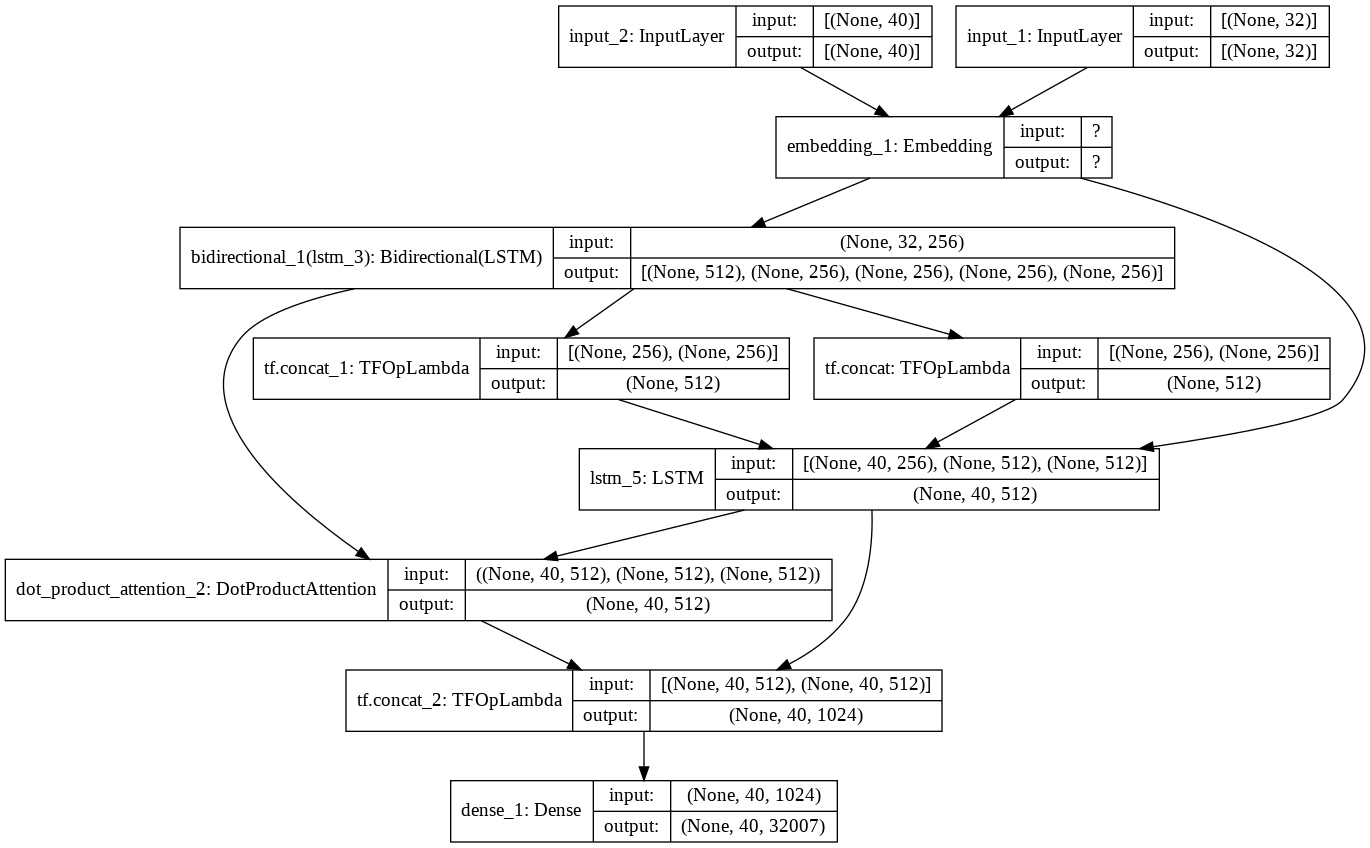

In [43]:
# 모델 생성
model = build_model(len(vocab), d_model, n_enc_seq, n_dec_seq)
# 모델 내용 그래프 출력
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

# Vocabulary & config

In [41]:
# vocab loading
vocab = spm.SentencePieceProcessor()
vocab.load(os.path.join(data_dir, 'ko_32000.model'))

True

In [42]:
n_vocab = len(vocab)  # number of vocabulary
n_enc_seq = 32  # number of sequence 1
n_dec_seq = 40  # number of sequence 2
d_model = 256  # dimension of model

# Loss & Acc

In [44]:
def lm_loss(y_true, y_pred):
    """
    pad 부분을 제외하고 loss를 계산하는 함수
    :param y_true: 정답
    :param y_pred: 예측 값
    :retrun loss: pad 부분이 제외된 loss 값
    """
    # loss = sparse_entropy = tf.keras.losses.SparseCategoricalCrossentropy()(y_true, y_pred)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)(y_true, y_pred)
    mask = tf.not_equal(y_true, 0)
    mask = tf.cast(mask, tf.float32)
    # print(mask)
    loss *= mask
    return loss

In [45]:
def lm_acc(y_true, y_pred):
    """
    pad 부분을 제외하고 accuracy를 계산하는 함수
    :param y_true: 정답
    :param y_pred: 예측 값
    :retrun loss: pad 부분이 제외된 accuracy 값
    """
    y_true = tf.cast(y_true, tf.float32)
    # print(y_true)
    y_pred_class = tf.cast(tf.argmax(y_pred, axis=-1), tf.float32)
    # print(y_pred_class)
    matches = tf.cast(tf.equal(y_true, y_pred_class), tf.float32)
    # print(matches)
    mask = tf.not_equal(y_true, 0)
    mask = tf.cast(mask, tf.float32)
    # print(mask)
    matches *= mask
    # print(matches)
    # accuracy = tf.reduce_sum(matches) / tf.maximum(tf.reduce_sum(tf.ones_like(matches)), 1)
    accuracy = tf.reduce_sum(matches) / tf.maximum(tf.reduce_sum(mask), 1)
    return accuracy

# Sample Data Project

## Data


In [46]:
df_train = pd.read_csv(os.path.join(songys_dir, 'ChatbotData.csv'))
df_train

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0
...,...,...,...
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.,2
11820,흑기사 해주는 짝남.,설렜겠어요.,2
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.,2


In [47]:
df_train = df_train.dropna()
df_train

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0
...,...,...,...
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.,2
11820,흑기사 해주는 짝남.,설렜겠어요.,2
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.,2


In [48]:
# 랜덤하게 10개만 확인
df_train = df_train.sample(10)
df_train

,Q,A,label
9996,사랑한 만큼 배려해야했어,이제야 깨달았나봐요.,2
10749,연애하는데도 외로워,진정한 사랑을 찾아보세요.,2
473,나 노트북 사줘,노트북은 비싸요.,0
6841,아무리 기다려도 이젠 안돌아오나봐,그게 끝이라면 받아들여야 해요.,1
5696,기다리다 지친듯해,몸도 마음도 쉬세요.,1
8074,정말. 정말 쉽지가 않네. 이럴 땐 어떡해야 할까,마음 가는 대로 하세요.,1
6554,비오는날,마음이 가라 앉죠.,1
7746,이젠 붙잡을 수 도 없는 사람.,달라지는게 없다면 이런 상황이 더 나을지도 몰라요.,1
2196,비 오는 날은 만나서 뭐할까,실내 데이트가 좋겠네요.,0
7723,이제는 이별을 받아드리려고 합니다,이별을 받아들이는 것도 중요해요.,1


In [49]:
def load_data(df, n_enc_seq, n_dec_seq):
    """
    Quora 학습 데이터 생성
    :param df: data frame
    :param n_enc_seq: number of encoder sequence
    :param n_dec_seq: number of decoder sequence
    :return enc_inputs: encoder input data
    :return dec_inputs: decoder input data
    :return labels: label data
    """
    n_enc_max = n_enc_seq
    n_dec_max = n_dec_seq - 1
    enc_inputs = np.zeros((len(df), n_enc_seq)).astype(np.int32)
    dec_inputs = np.zeros((len(df), n_dec_seq)).astype(np.int32)
    labels = np.zeros((len(df), n_dec_seq)).astype(np.int32)
    index = 0
    for i, row in tqdm(df.iterrows(), total=len(df)):
        # tokens 저장
        print()
        Q = row['Q']
        A = row['A']
        print(Q, '/', A)

        tokens_q = vocab.encode_as_pieces(Q)
        print(len(tokens_q), ':', tokens_q)
        tokens_a = vocab.encode_as_pieces(A)
        print(len(tokens_a), ':', tokens_a)

        tokens_ids_q = vocab.encode_as_ids(Q)[:n_enc_max]
        print(len(tokens_ids_q), ':', tokens_ids_q)
        tokens_ids_a = vocab.encode_as_ids(A)[:n_dec_max]
        print(len(tokens_ids_a), ':', tokens_ids_a)

        tokens_dec_in = [vocab.bos_id()] + tokens_ids_a
        tokens_dec_out = tokens_ids_a + [vocab.eos_id()]

        tokens_ids_q += [0] * (n_enc_seq - len(tokens_ids_q))
        print(len(tokens_ids_q), ':', tokens_ids_q)
        tokens_dec_in += [0] * (n_dec_seq - len(tokens_dec_in))
        print(len(tokens_dec_in), ':', tokens_dec_in)
        tokens_dec_out += [0] * (n_dec_seq - len(tokens_dec_out))
        print(len(tokens_dec_out), ':', tokens_dec_out)

        enc_inputs[index] = tokens_ids_q
        dec_inputs[index] = tokens_dec_in
        labels[index] = tokens_dec_out
        index += 1
    return enc_inputs, dec_inputs, labels

In [50]:
# train data 생성
train_enc_inputs, train_dec_inputs, train_labels = load_data(df_train, n_enc_seq, n_dec_seq)
train_enc_inputs, train_dec_inputs, train_labels


사랑한 만큼 배려해야했어 / 이제야 깨달았나봐요.
7 : ['▁사랑', '한', '▁만큼', '▁배려', '해야', '했', '어']
9 : ['▁이제', '야', '▁깨', '달', '았', '나', '봐', '요', '.']
7 : [1816, 33, 2881, 14519, 755, 5120, 110]
9 : [3379, 173, 4221, 726, 9815, 58, 15346, 431, 7]
32 : [1816, 33, 2881, 14519, 755, 5120, 110, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
40 : [2, 3379, 173, 4221, 726, 9815, 58, 15346, 431, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
40 : [3379, 173, 4221, 726, 9815, 58, 15346, 431, 7, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

연애하는데도 외로워 / 진정한 사랑을 찾아보세요.
6 : ['▁연애', '하는데', '도', '▁외', '로', '워']
6 : ['▁진정한', '▁사랑을', '▁찾아', '보', '세요', '.']
6 : [8256, 987, 32, 538, 21, 1384]
6 : [9022, 5775, 2309, 191, 15319, 7]
32 : [8256, 987, 32, 538, 21, 1384, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
40 : [2, 9022, 5775, 2309, 191, 15319, 7, 0, 0, 0, 0, 0, 0, 0, 

(array([[ 1816,    33,  2881, 14519,   755,  5120,   110,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0],
        [ 8256,   987,    32,   538,    21,  1384,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0],
        [  339, 25427,   207, 14904,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0],
        [19228, 27953,    32,    29,  2201,   295, 26022,   177,    58,
         15346,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
 

## 학습

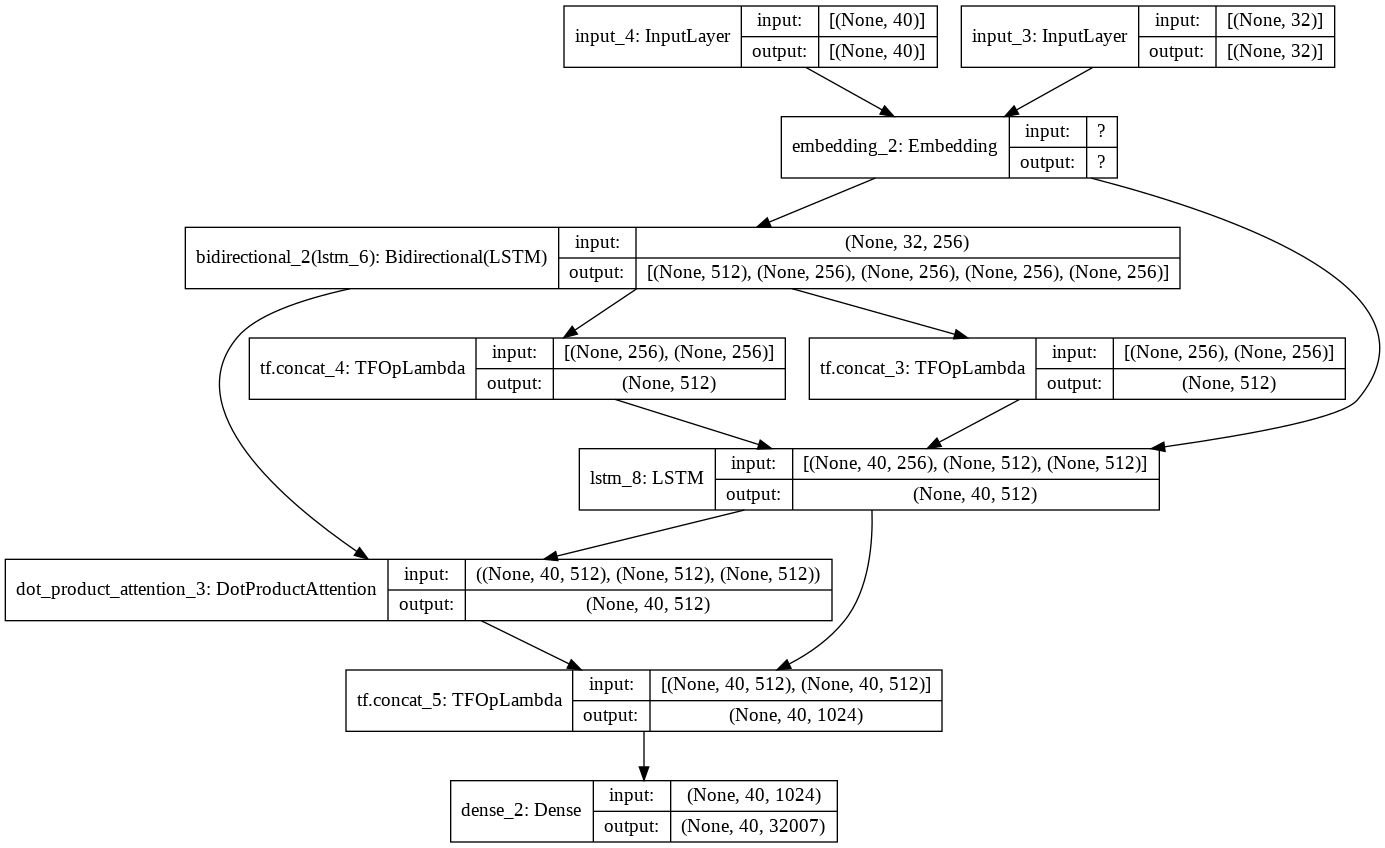

In [51]:
# 모델 생성
model = build_model(len(vocab), d_model, n_enc_seq, n_dec_seq)
# 모델 내용 그래프 출력
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [52]:
# 모델 loss, optimizer, metric 정의
model.compile(loss=lm_loss, optimizer='adam', metrics=[lm_acc])

In [53]:
# early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='lm_acc', patience=100)
# save weights callback
save_weights = tf.keras.callbacks.ModelCheckpoint(os.path.join(songys_dir, 'lstm_dot.hdf5'),
                                                  monitor='lm_acc',
                                                  verbose=1,
                                                  save_best_only=True,
                                                  mode="max",
                                                  save_freq="epoch",
                                                  save_weights_only=True)
# csv logger
csv_logger = tf.keras.callbacks.CSVLogger(os.path.join(songys_dir, 'lstm_dot.csv'))

In [54]:
# 모델 학습
history = model.fit((train_enc_inputs, train_dec_inputs),
                    train_labels,
                    epochs=400,
                    batch_size=256,
                    callbacks=[early_stopping, save_weights, csv_logger])

Epoch 1/400
1/1 [==============================] - 4s 4s/step - loss: 2.2822 - lm_acc: 0.0000e+00

Epoch 00001: lm_acc improved from -inf to 0.00000, saving model to /content/drive/MyDrive/NLP_data/songys/lstm_dot.hdf5
Epoch 2/400
1/1 [==============================] - 0s 152ms/step - loss: 2.2788 - lm_acc: 0.1136

Epoch 00002: lm_acc improved from 0.00000 to 0.11364, saving model to /content/drive/MyDrive/NLP_data/songys/lstm_dot.hdf5
Epoch 3/400
1/1 [==============================] - 0s 166ms/step - loss: 2.2732 - lm_acc: 0.1136

Epoch 00003: lm_acc did not improve from 0.11364
Epoch 4/400
1/1 [==============================] - 0s 118ms/step - loss: 2.2611 - lm_acc: 0.1136

Epoch 00004: lm_acc did not improve from 0.11364
Epoch 5/400
1/1 [==============================] - 0s 113ms/step - loss: 2.2310 - lm_acc: 0.1136

Epoch 00005: lm_acc did not improve from 0.11364
Epoch 6/400
1/1 [==============================] - 0s 120ms/step - loss: 2.1498 - lm_acc: 0.1136

Epoch 00006: lm_acc d

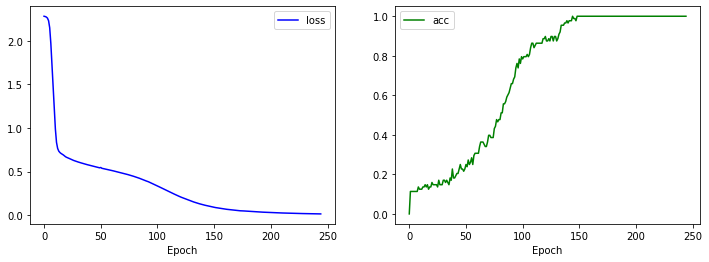

In [55]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['lm_acc'], 'g-', label='acc')
plt.xlabel('Epoch')
plt.legend()

plt.show()

## Inference

In [56]:
# 모델 생성
model = build_model(len(vocab), d_model, n_enc_seq, n_dec_seq)
# train weight로 초기화
model.load_weights(os.path.join(songys_dir, 'lstm_dot.hdf5'))

In [57]:
def do_chat(vocab, model, n_enc_seq, n_dec_seq, string):
    """
    seq2seq chat
    :param vocab: vocab
    :param model: model
    :param n_enc_seq: number of enc seqence
    :param n_dec_seq: number of dec seqence
    :param string: inpust string
    """
    # qeustion
    q = vocab.encode_as_pieces(string)
    q_id = [vocab.piece_to_id(p) for p in q][:n_enc_seq]
    q_id += [0] * (n_enc_seq - len(q_id))
    assert len(q_id) == n_enc_seq

    # answer
    a_id = [vocab.bos_id()]
    a_id += [0] * (n_dec_seq - len(a_id))
    assert len(a_id) == n_dec_seq

    # 처음부터 예측
    start_idx = 0

    for _ in range(start_idx, n_dec_seq - 1):
        outputs = model.predict((np.array([q_id]), np.array([a_id])))
        prob = outputs[0][start_idx]
        word_id = np.argmax(prob)
        if word_id == vocab.eos_id():
            break
        a_id[start_idx + 1] = int(word_id)
        start_idx += 1
    predict_id = a_id[1:start_idx + 1]
    predict_str = vocab.decode_ids(predict_id)
    return predict_str

In [58]:
while True:
    string = input('질문 > ')
    string = string.strip()
    if len(string) == 0:
        break
    predict_str = do_chat(vocab, model, n_enc_seq, n_dec_seq, string)
    print(f'답변 > {predict_str}')

질문 > 안녕하세요
답변 > 마음이 가라 앉죠.
질문 > 안녕
답변 > 실내 데이트가 좋겠네요.
질문 > 날씨가 좋아
답변 > 마음이 가라 앉죠.
질문 > 어떤 기분이야?
답변 > 마음이 가라 앉죠.
질문 > 기분이 나빠
답변 > 마음이 가라 앉죠.
질문 > 우울해
답변 > 실내 데이트가 좋겠네요.
질문 > 졸려
답변 > 실내 데이트가 좋겠네요.
질문 > 데이트 안 해
답변 > 마음이 가라 앉죠.
질문 > 그래
답변 > 실내 데이트가 좋겠네요.
질문 > 아니
답변 > 실내 데이트가 좋겠네요.
질문 > 


# All Data Project

## Data


In [59]:
df_train = pd.read_csv(os.path.join(songys_dir, 'ChatbotData.csv'))
print(len(df_train))
df_train = df_train.dropna()
print(len(df_train))
df_train

11823
11823


,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0
...,...,...,...
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.,2
11820,흑기사 해주는 짝남.,설렜겠어요.,2
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.,2


In [60]:
def load_data(df, n_enc_seq, n_dec_seq):
    """
    Quora 학습 데이터 생성
    :param df: data frame
    :param n_enc_seq: number of encoder sequence
    :param n_dec_seq: number of decoder sequence
    :return enc_inputs: encoder input data
    :return dec_inputs: decoder input data
    :return labels: label data
    """
    n_enc_max = n_enc_seq
    n_dec_max = n_dec_seq - 1
    enc_inputs = np.zeros((len(df), n_enc_seq)).astype(np.int32)
    dec_inputs = np.zeros((len(df), n_dec_seq)).astype(np.int32)
    labels = np.zeros((len(df), n_dec_seq)).astype(np.int32)
    index = 0
    for i, row in tqdm(df.iterrows(), total=len(df)):
        # tokens 저장
        Q = row['Q']
        A = row['A']

        tokens_q = vocab.encode_as_pieces(Q)
        tokens_a = vocab.encode_as_pieces(A)

        tokens_ids_q = vocab.encode_as_ids(Q)[:n_enc_max]
        tokens_ids_a = vocab.encode_as_ids(A)[:n_dec_max]

        tokens_dec_in = [vocab.bos_id()] + tokens_ids_a
        tokens_dec_out = tokens_ids_a + [vocab.eos_id()]

        tokens_ids_q += [0] * (n_enc_seq - len(tokens_ids_q))
        tokens_dec_in += [0] * (n_dec_seq - len(tokens_dec_in))
        tokens_dec_out += [0] * (n_dec_seq - len(tokens_dec_out))

        enc_inputs[index] = tokens_ids_q
        dec_inputs[index] = tokens_dec_in
        labels[index] = tokens_dec_out
        index += 1
    return enc_inputs, dec_inputs, labels

In [61]:
# train data 생성
train_enc_inputs, train_dec_inputs, train_labels = load_data(df_train, n_enc_seq, n_dec_seq)
train_enc_inputs, train_dec_inputs, train_labels

(array([[   89,    56,    10, ...,     0,     0,     0],
        [   35,    47,  1004, ...,     0,     0,     0],
        [   38,   819,   362, ...,     0,     0,     0],
        ...,
        [ 2886,  9525, 21930, ...,     0,     0,     0],
        [10736,  8256,  1172, ...,     0,     0,     0],
        [26128,    70,  1381, ...,     0,     0,     0]], dtype=int32),
 array([[    2,  2261,    19, ...,     0,     0,     0],
        [    2,  4594,    61, ...,     0,     0,     0],
        [    2,  2350,    18, ...,     0,     0,     0],
        ...,
        [    2,  1522,     1, ...,     0,     0,     0],
        [    2,   441, 10316, ...,     0,     0,     0],
        [    2, 16665,    90, ...,     0,     0,     0]], dtype=int32),
 array([[ 2261,    19,   375, ...,     0,     0,     0],
        [ 4594,    61,   929, ...,     0,     0,     0],
        [ 2350,    18,  9001, ...,     0,     0,     0],
        ...,
        [ 1522,     1, 12273, ...,     0,     0,     0],
        [  441, 103

## 학습

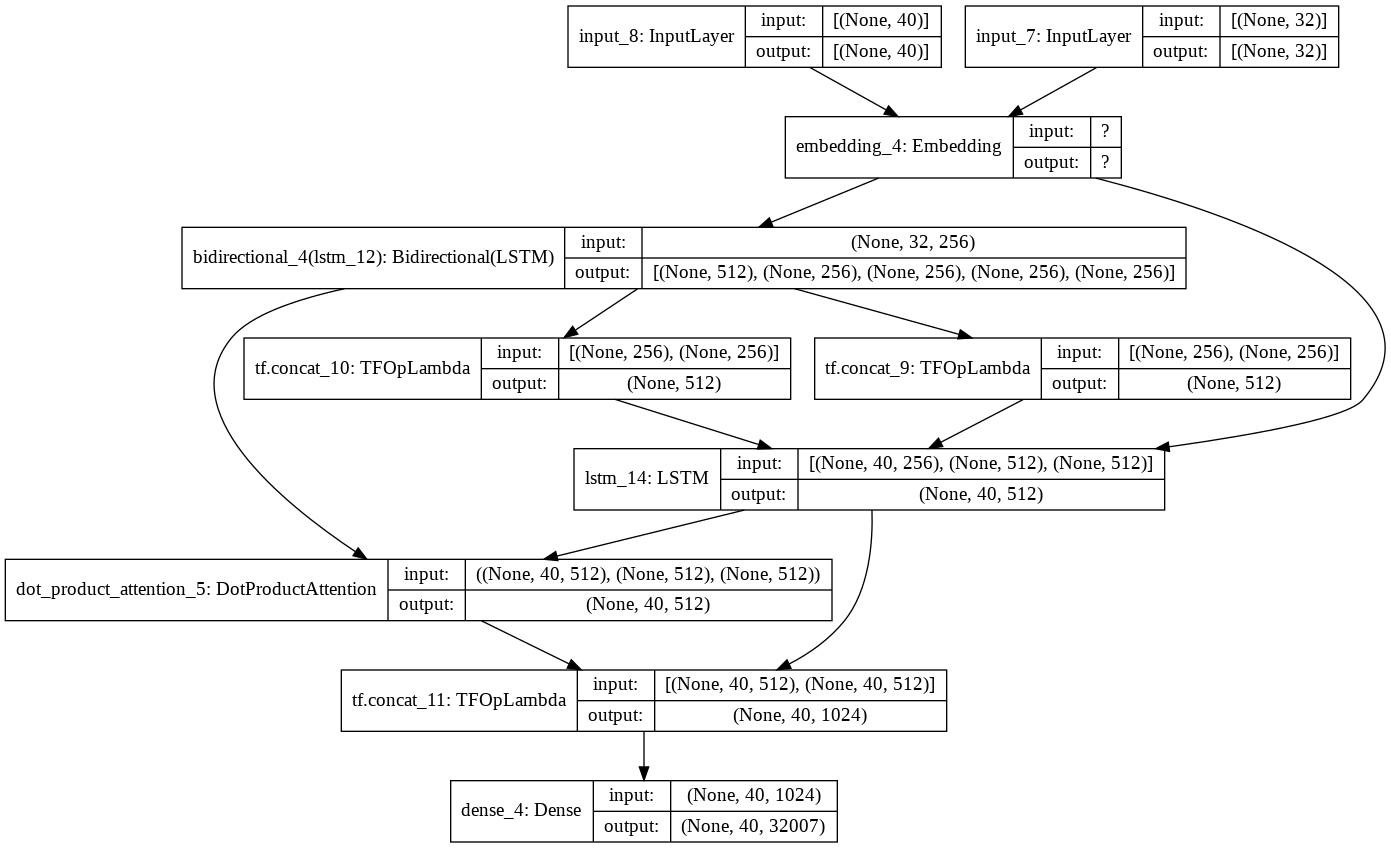

In [62]:
# 모델 생성
model = build_model(len(vocab), d_model, n_enc_seq, n_dec_seq)
# 모델 내용 그래프 출력
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [63]:
# 모델 loss, optimizer, metric 정의
model.compile(loss=lm_loss, optimizer='adam', metrics=[lm_acc])

In [64]:
# early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='lm_acc', patience=5)
# save weights callback
save_weights = tf.keras.callbacks.ModelCheckpoint(os.path.join(songys_dir, 'lstm_dot.hdf5'),
                                                  monitor='lm_acc',
                                                  verbose=1,
                                                  save_best_only=True,
                                                  mode="max",
                                                  save_freq="epoch",
                                                  save_weights_only=True)
# csv logger
csv_logger = tf.keras.callbacks.CSVLogger(os.path.join(songys_dir, 'lstm_dot.csv'))

In [65]:
# 모델 학습
history = model.fit((train_enc_inputs, train_dec_inputs),
                    train_labels,
                    epochs=100,
                    batch_size=256,
                    callbacks=[early_stopping, save_weights, csv_logger])

Epoch 1/100
47/47 [==============================] - 26s 481ms/step - loss: 1.8574 - lm_acc: 0.1037

Epoch 00001: lm_acc improved from -inf to 0.12046, saving model to /content/drive/MyDrive/NLP_data/songys/lstm_dot.hdf5
Epoch 2/100
47/47 [==============================] - 23s 486ms/step - loss: 1.2719 - lm_acc: 0.1731

Epoch 00002: lm_acc improved from 0.12046 to 0.20251, saving model to /content/drive/MyDrive/NLP_data/songys/lstm_dot.hdf5
Epoch 3/100
47/47 [==============================] - 23s 482ms/step - loss: 1.1342 - lm_acc: 0.2743

Epoch 00003: lm_acc improved from 0.20251 to 0.28395, saving model to /content/drive/MyDrive/NLP_data/songys/lstm_dot.hdf5
Epoch 4/100
47/47 [==============================] - 23s 483ms/step - loss: 1.0633 - lm_acc: 0.3151

Epoch 00004: lm_acc improved from 0.28395 to 0.32542, saving model to /content/drive/MyDrive/NLP_data/songys/lstm_dot.hdf5
Epoch 5/100
47/47 [==============================] - 23s 483ms/step - loss: 1.0017 - lm_acc: 0.3511

Epoch 

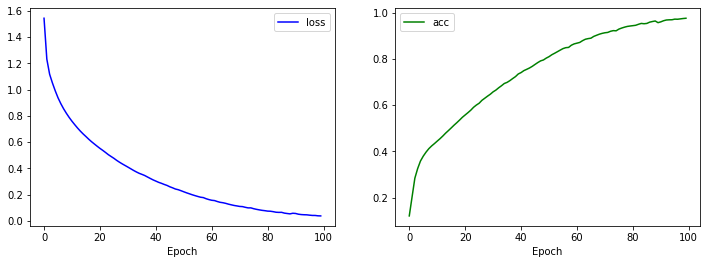

In [70]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['lm_acc'], 'g-', label='acc')
plt.xlabel('Epoch')
plt.legend()

plt.show()

## Inference

In [67]:
# 모델 생성
model = build_model(len(vocab), d_model, n_enc_seq, n_dec_seq)
# train weight로 초기화
model.load_weights(os.path.join(songys_dir, 'lstm_dot.hdf5'))

In [68]:
def do_chat(vocab, model, n_enc_seq, n_dec_seq, string):
    """
    seq2seq chat
    :param vocab: vocab
    :param model: model
    :param n_enc_seq: number of enc seqence
    :param n_dec_seq: number of dec seqence
    :param string: inpust string
    """
    # qeustion
    q = vocab.encode_as_pieces(string)
    q_id = [vocab.piece_to_id(p) for p in q][:n_enc_seq]
    q_id += [0] * (n_enc_seq - len(q_id))
    assert len(q_id) == n_enc_seq

    # answer
    a_id = [vocab.bos_id()]
    a_id += [0] * (n_dec_seq - len(a_id))
    assert len(a_id) == n_dec_seq

    # 처음부터 예측
    start_idx = 0

    for _ in range(start_idx, n_dec_seq - 1):
        outputs = model.predict((np.array([q_id]), np.array([a_id])))
        prob = outputs[0][start_idx]
        word_id = np.argmax(prob)
        if word_id == vocab.eos_id():
            break
        a_id[start_idx + 1] = int(word_id)
        start_idx += 1
    predict_id = a_id[1:start_idx + 1]
    predict_str = vocab.decode_ids(predict_id)
    return predict_str

In [69]:
while True:
    string = input('질문 > ')
    string = string.strip()
    if len(string) == 0:
        break
    predict_str = do_chat(vocab, model, n_enc_seq, n_dec_seq, string)
    print(f'답변 > {predict_str}')

질문 > 안녕
답변 > 안녕하세요.
질문 > 너도 우리 강아지가 귀엽니?
답변 > 매일 조금씩 먹으면 좋죠.
질문 > 너 강아지 먹어..?
답변 > 긍정적이네요.
질문 > 요즘 재밌는 뮤지컬 뭐야?
답변 > 적에서 내일이 쉽죠.
질문 > 재밌는 연극 뭐야?
답변 > 잼 있는 거는 딸기잼에게 물어봐 주세요.
질문 > 노잼...
답변 > 곧 방학이예요.
질문 > 오늘 며칠이야?
답변 > 직접 물어보세요.
질문 > ㅋㅋㅋㅋㅋㅋㅋㅋㅋ
답변 > 아무래도 부담되면 마음이 가지 않는 거니 이해해주세요.
질문 > 고양이 귀여워
답변 > 천천히 깨요.
질문 > 뭘 깨?
답변 > 활기찬 사람이 있으면 좋겠네요.
질문 > 하루에 물 몇 잔 마셔?
답변 > 정말 많이 사랑주세요.
질문 > 구글
답변 > 그 사람도 당신을 사랑하고 있어요.
질문 > 머리가 길어
답변 > 잠시 휴식기를 가져요.
질문 > 손시려워
답변 > 천천히 생각해봐요.
질문 > 따뜻해
답변 > 현재를 즐기세요!
질문 > 그래
답변 > 오늘 미세먼한 곳으로일 뿐이에요.
질문 > 아니
답변 > 혼자인 기분이에요.
질문 > 힘내
답변 > 현재를 즐기세요!
질문 > 
